In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
import concurrent.futures
import multiprocessing
import tqdm
from functools import partial

sys.path.append('/zliu_ssd/CHARM/upload/')
sys.path.append('/zliu_ssd/CHARM/upload/CHARMtools/')
import CHARMtools
from CHARMtools.analysis import spatialstat
from CHARMtools.obj import Cell3D

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_515081/3535460749.py:27: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [3]:
metadata = pd.read_csv('/zliu_ssd/CHARM/CHARM_mesc/data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2]

rnag1 = pd.read_csv("/zliu_ssd/CHARM/CHARM_mesc/data/RNAmats/counts.gene.genome1.format.tsv.gz",sep='\t')
rnag2 = pd.read_csv("/zliu_ssd/CHARM/CHARM_mesc/data/RNAmats/counts.gene.genome2.format.tsv.gz",sep='\t')
genes = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",sep='\t',header=None)
genes.columns = ["chrom","start","end","id","gene","strand"]

In [4]:
## 用fragment数给各种particle分类 
ct_frags = pd.read_csv("/zliu_ssd/CHARM/CHARM_mesc/1_preprocess/pseudobulk/ct.fragments.gz",header=None,sep="\t").iloc[:,:3]
atac_frags = pd.read_csv("/zliu_ssd/CHARM/CHARM_mesc/1_preprocess/pseudobulk/atac.fragments.gz",header=None,sep="\t").iloc[:,:3]
ct_frags.columns = ["chrom","start","end"]
atac_frags.columns = ["chrom","start","end"]

ct_frags["pos"] =  ((ct_frags["start"] + ct_frags["end"]) / 2 // 5000 * 5000).astype(int)
atac_frags["pos"] =  ((atac_frags["start"] + atac_frags["end"]) / 2 // 5000 * 5000).astype(int)

ct_frags = ct_frags.groupby(["chrom","pos"]).size().reset_index(name="count")
atac_frags = atac_frags.groupby(["chrom","pos"]).size().reset_index(name="count")

compartment = pd.read_csv("/sharec/zliu/archieve/else/research/publicData/Bonev2017/processedData/processed/compartment/ES.compartment.100k.cis.vecs.tsv",sep="\t")
compartment = compartment.query('E1 > 0').loc[:,["chrom","start","end"]].reset_index()

allparticles = pd.merge(ct_frags, atac_frags, on=["chrom","pos"], how="inner")
allparticles.columns = ["chrom","pos","ct","atac"]
chroms = ["chr"+str(i) for i in range(1,20)] + ["chrX"]
allparticles.query("chrom in @chroms", inplace=True)

# keep a compartmnet particles
allparticles["start"] = allparticles["pos"] // 100000 * 100000
allparticles = allparticles.merge(compartment[["chrom","start"]], on=["chrom","start"], how="inner")

# standardscaler on comp
allparticles[["atac_norm","ct_norm"]] = StandardScaler().fit_transform(np.log1p(allparticles[["atac","ct"]]))
allparticles["particle_type"] = "Else"
allparticles.loc[(allparticles["atac_norm"] >= 0) & (allparticles["ct_norm"] >= 0), "particle_type"] = "Both_high"
allparticles.loc[(allparticles["atac_norm"] < 0) & (allparticles["ct_norm"] < 0), "particle_type"] = "Both_low"
allparticles.loc[(allparticles["atac_norm"] >= 0) & (allparticles["ct_norm"] < 0), "particle_type"] = "ATAC_high"
allparticles.loc[(allparticles["atac_norm"] < 0) & (allparticles["ct_norm"] >= 0), "particle_type"] = "CT_high"

In [20]:
allparticles_allele_specific = pd.concat([
    allparticles.assign(chrom = allparticles["chrom"].astype(str) + 'a'),
    allparticles.assign(chrom = allparticles["chrom"].astype(str) + 'b')
])

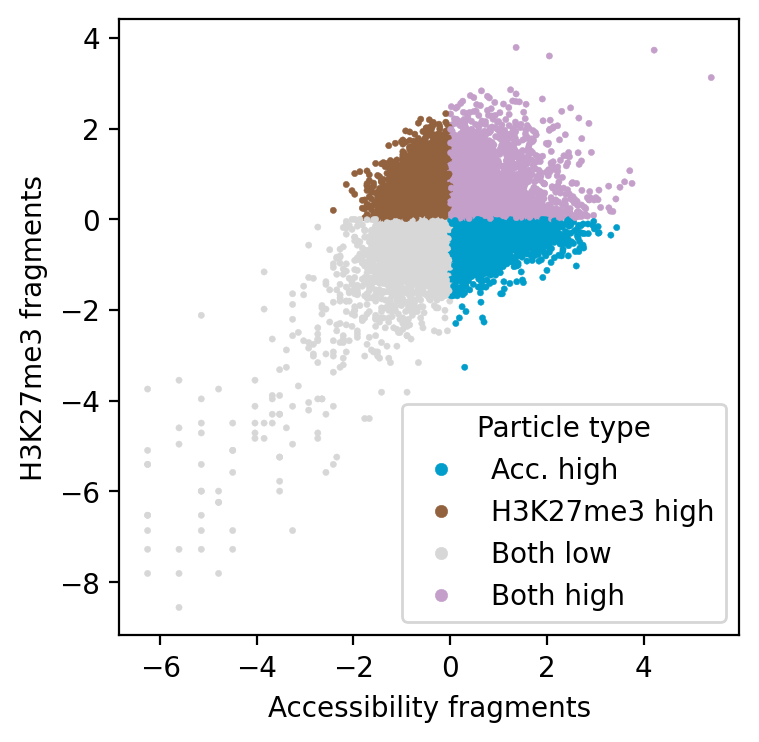

In [58]:
plt.figure(figsize=(4, 4))

sns.scatterplot(data=allparticles.sample(10000,random_state=42),x="atac_norm",y="ct_norm",hue="particle_type",
                s=5,palette={"Both high":"#c39fca","Both low":"#d7d7d7","Acc. high":"#029ecb","H3K27me3 high":"#92613e","Else":"#7f7f7f"},edgecolor=None,alpha=1,rasterized=True)

plt.legend(title="Particle type",markerscale=2)
plt.xlabel("Accessibility fragments")
plt.ylabel("H3K27me3 fragments")

plt.savefig("figures/particle_types.pdf",bbox_inches='tight')

In [21]:
def _load_cell(cellname, resolution):
    cell = Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"/zliu_ssd/CHARM/CHARM_mesc/data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"/zliu_ssd/CHARM/CHARM_mesc/data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", 
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    cell.add_bed_data(path=f"/zliu_ssd/CHARM/CHARM_mesc/data/fragments/ct_frags/{cellname}.ct.frag.bed.gz", 
                     column_name="ct" ,keep_3prime=True,type="allelic_resolved")
    
    cell.add_bed_data(path=f"/zliu_ssd/CHARM/CHARM_mesc/1_preprocess/atacpeak_score50.bed",column_name="atac_peaks",keep_3prime=False,type="all")
    cell.add_bed_data(path=f"/zliu_ssd/CHARM/CHARM_mesc/data/publicdata/ENCODE/ENCFF008XKX_encode_mESCBruce4_H3K27me3.bed.gz",column_name="me3_peaks",keep_3prime=False,type="all")
    cell.add_bed_data(path=f"../bivalent_single_allele/bivalent_peaks.bed",column_name="bivalent_peaks",keep_3prime=False,type="all")
    
    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes,type = "tss")
    cell.tdg = cell.tdg.merge(allparticles_allele_specific[["chrom","pos","particle_type"]],on = ["chrom","pos"],how ="left")
    cell.tdg["particle_type"].fillna("Else",inplace=True)
    
    cell.subset(query='atac > 0 or ct > 0 or UMI >= 1 or atac_peaks > 0 or me3_peaks > 0 or particle_type != "Else" or bivalent_peaks > 0',in_place=True)
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [13:10<00:00,  1.10s/it] 


In [22]:
def _calc_spatial_crosscorr(cell,query1,query2):
    np.random.seed(42)
    df = cell.get_data()
    points1 = df.query(query1)[["x","y","z"]].values.copy()
    points2 = df.query(query2)[["x","y","z"]].values.copy()

    if points1.shape[0] > 5000:
        points1 = points1[np.random.choice(points1.shape[0], 5000, replace=False), :]
    if points2.shape[0] > 5000:
        points2 = points2[np.random.choice(points2.shape[0], 5000, replace=False), :]

    return spatialstat.spatial_crosscorr_3d(points1,points2,dr=1,max_dist=10,Nsim=4)[0]


with concurrent.futures.ProcessPoolExecutor(max_workers=50,mp_context=multiprocessing.get_context("fork")) as executor:
    acc_acchigh_rna = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='atac > 0 & particle_type == "Acc. high"',query2='UMI >= 1'),cells), total=len(cells)))
    accme3_bothhigh_rna = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='atac > 0 & ct > 0 & particle_type == "Both high"',query2='UMI >= 1'),cells), total=len(cells)))
    me3_me3high_rna = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='ct > 0 & particle_type == "H3K27me3 high"',query2='UMI >= 1'),cells), total=len(cells)))

    acc_acchigh_biv = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='atac > 0 & particle_type == "Acc. high"',query2='bivalent_peaks > 0'),cells), total=len(cells)))
    accme3_bothhigh_biv = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='atac > 0 & ct > 0 & particle_type == "Both high"',query2='bivalent_peaks > 0'),cells), total=len(cells)))
    me3_me3high_biv = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='ct > 0 & particle_type == "H3K27me3 high"',query2='bivalent_peaks > 0'),cells), total=len(cells)))



100%|██████████| 720/720 [02:53<00:00,  4.14it/s]


In [29]:
def _post_process_cor(autocorr):
    autocorr = np.array(autocorr)
    autocorr[np.isinf(autocorr)] = np.nan
    means = np.nanmean(autocorr,axis=0)
    stderr = np.nanstd(autocorr,axis=0) / np.sqrt(np.sum(~np.isnan(autocorr), axis=0))
    return means, stderr

acc_acchigh_rna_means, acc_acchigh_rna_stderr = _post_process_cor(acc_acchigh_rna)
accme3_bothhigh_rna_means, accme3_bothhigh_rna_stderr = _post_process_cor(accme3_bothhigh_rna)
me3_me3high_rna_means, me3_me3high_rna_stderr = _post_process_cor(me3_me3high_rna)

acc_acchigh_biv_means, acc_acchigh_biv_stderr = _post_process_cor(acc_acchigh_biv)
accme3_bothhigh_biv_means, accme3_bothhigh_biv_stderr = _post_process_cor(accme3_bothhigh_biv)
me3_me3high_biv_means, me3_me3high_biv_stderr = _post_process_cor(me3_me3high_biv)

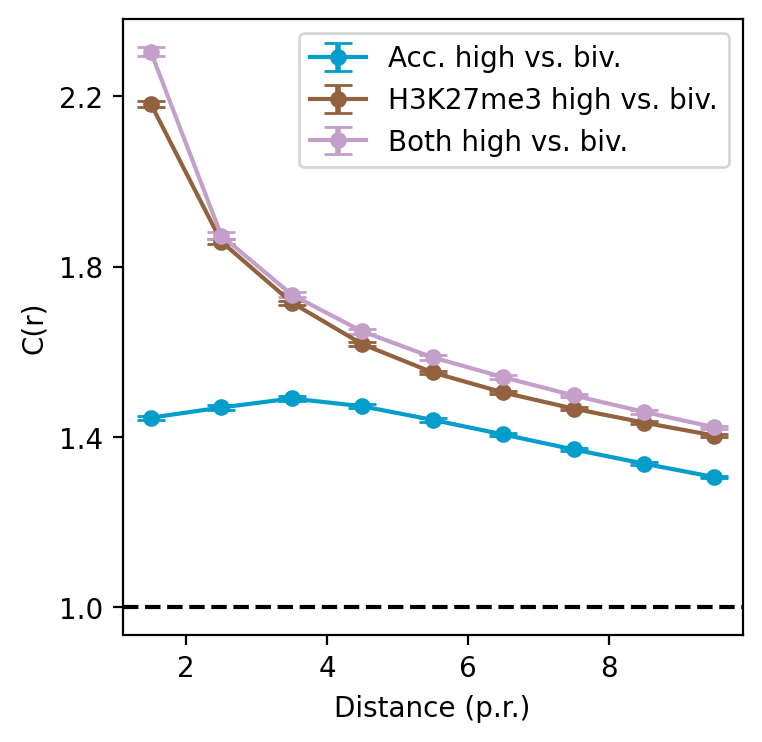

In [56]:
r = np.arange(0.5,10,1)
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))
start_i = 1

plt.errorbar(r[start_i:], acc_acchigh_biv_means[start_i:], yerr=acc_acchigh_biv_stderr[start_i:], label='Acc. high vs. biv.',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,fmt='-o',color="#029ecb",ecolor="#029ecb")
plt.errorbar(r[start_i:], me3_me3high_biv_means[start_i:], yerr=me3_me3high_biv_stderr[start_i:], label='H3K27me3 high vs. biv.',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,fmt='-o',color="#92613e",ecolor="#92613e")
plt.errorbar(r[start_i:], accme3_bothhigh_biv_means[start_i:], yerr=accme3_bothhigh_biv_stderr[start_i:], label='Both high vs. biv.',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,fmt='-o',color="#c39fca",ecolor="#c39fca")
plt.axhline(y=1, color='black', linestyle='--')
plt.ylabel('C(r)')
plt.xlabel('Distance (p.r.)')
# plt.xlim(0.75, 8)
#plt.ylim(0.9,2.6)
plt.yticks([1.0,1.4,1.8,2.2],["1.0","1.4","1.8","2.2"])
plt.legend()

plt.savefig("figures/spatial_crosscor_accme3_biv.pdf",bbox_inches='tight')

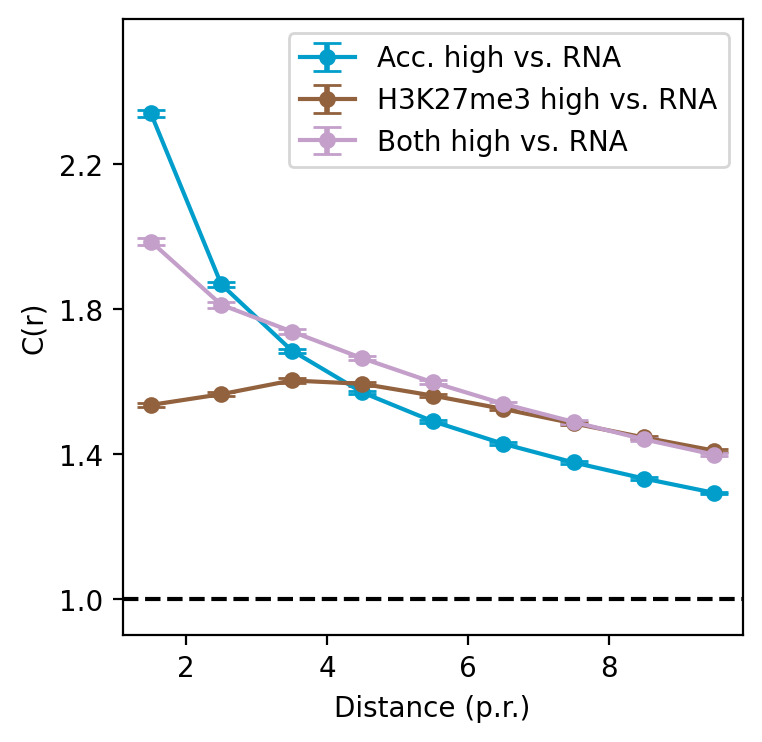

In [57]:
r = np.arange(0.5,10,1)
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))
start_i = 1

plt.errorbar(r[start_i:], acc_acchigh_rna_means[start_i:], yerr=acc_acchigh_rna_stderr[start_i:], label='Acc. high vs. RNA',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,fmt='-o',color="#029ecb",ecolor="#029ecb")
plt.errorbar(r[start_i:], me3_me3high_rna_means[start_i:], yerr=me3_me3high_rna_stderr[start_i:], label='H3K27me3 high vs. RNA',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,fmt='-o',color="#92613e",ecolor="#92613e")
plt.errorbar(r[start_i:], accme3_bothhigh_rna_means[start_i:], yerr=accme3_bothhigh_rna_stderr[start_i:], label='Both high vs. RNA',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,fmt='-o',color="#c39fca",ecolor="#c39fca")
plt.axhline(y=1, color='black', linestyle='--')
plt.ylabel('C(r)')
plt.xlabel('Distance (p.r.)')
# plt.xlim(0.75, 8)
plt.ylim(0.9,2.6)
plt.yticks([1.0,1.4,1.8,2.2],["1.0","1.4","1.8","2.2"])
plt.legend()

plt.savefig("figures/spatial_crosscor_accme3_rna.pdf",bbox_inches='tight')

In [52]:
def _load_cell_allpoints(cellname,resolution):
    cell = Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"/zliu_ssd/CHARM/CHARM_mesc/data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    cell.calc_radial_position(if_rank=True)
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    cells_allpoints = list(tqdm.tqdm(executor.map(_load_cell_allpoints, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [01:30<00:00,  7.94it/s]


In [53]:
with concurrent.futures.ProcessPoolExecutor(max_workers=50,mp_context=multiprocessing.get_context("fork")) as executor:
    #atac_ct = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='atac > 0',query2='ct > 0'),cells), total=len(cells)))
    #ct_rna = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='ct > 0',query2='UMI >= 1'),cells), total=len(cells)))
    #atac_rna = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='atac > 0',query2='UMI >= 1'),cells), total=len(cells)))
    random_random = list(tqdm.tqdm(executor.map(partial(_calc_spatial_crosscorr,query1='chrom_code >= 0',query2='chrom_code >= 0'),cells_allpoints), total=len(cells_allpoints)))


means_atac_ct, stderr_atac_ct = _post_process_cor(atac_ct)
means_ct_rna, stderr_ct_rna = _post_process_cor(ct_rna)
means_atac_rna, stderr_atac_rna = _post_process_cor(atac_rna)
means_random_random, stderr_random_random = _post_process_cor(random_random)

100%|██████████| 720/720 [03:04<00:00,  3.90it/s]


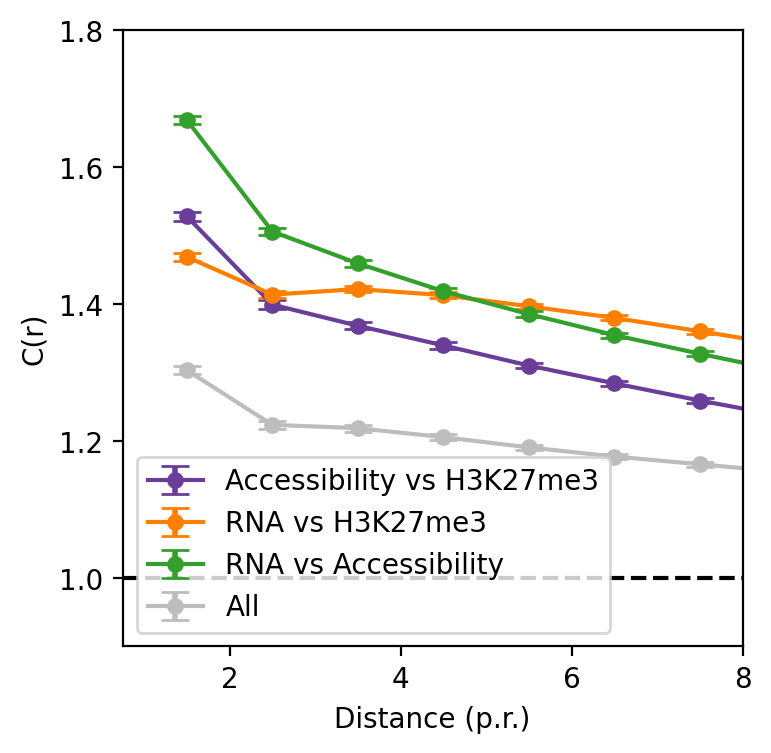

In [55]:
r = np.arange(0.5,10,1)

%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(4, 4))
# start_i = 1
start_i = 1
plt.errorbar(r[start_i:],means_atac_ct[start_i:],yerr=stderr_atac_ct[start_i:],label='Accessibility vs H3K27me3',fmt='-o',ecolor='#6a3d9a',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#6a3d9a')
plt.errorbar(r[start_i:],means_ct_rna[start_i:],yerr=stderr_ct_rna[start_i:],label='RNA vs H3K27me3',fmt='-o',ecolor='#ff7f00',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#ff7f00')
plt.errorbar(r[start_i:],means_atac_rna[start_i:],yerr=stderr_ct_rna[start_i:],label='RNA vs Accessibility',fmt='-o',ecolor='#33a02c',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#33a02c')
plt.errorbar(r[start_i:],means_random_random[start_i:],yerr=stderr_ct_rna[start_i:],label='All',fmt='-o',ecolor='#bdbdbd',capsize=5,elinewidth=2,markeredgewidth=1,markersize=5,color='#bdbdbd')

plt.axhline(y=1, color='black', linestyle='--')
plt.ylabel('C(r)')
plt.xlabel('Distance (p.r.)')
plt.xlim(0.75, 8)
plt.ylim(0.9,1.8)
plt.yticks([1.0,1.2,1.4,1.6,1.8],["1.0","1.2","1.4","1.6","1.8"])
plt.legend()
plt.savefig('figures/spatial_crosscorr_all.pdf', bbox_inches='tight')
